In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from __future__ import print_function
import os
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
from keras.models import Model
from keras import backend as K
import matplotlib.pyplot as plt
from data import load_train_data, load_test_data,plot_imagesT
import pdb
from skimage.io import imsave, imread
import cv2
import pickle
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard, Callback
import data
import pylab
import imageio
import matplotlib.pyplot as plt
from  get_network import *
import params 
from os.path import splitext
from keras.utils import plot_model
from pathlib import Path
import dask.array as da
from dask.delayed import delayed
from dataloaders import *

/home/a252/Documents/Python/CCEPI/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
netparam=params.init() 
netprameval=params.init(train=0) 


{'randcrop': False, 'save_images': True, 'img_cols': 224, 'lr': 0.0001, 'CROP': False, 'affine': False, 'predict_batch_size': 5, 'lighting': False, 'Flip': False, 'optimizer': 'adam', 'dbg': False, 'img_rows': 224, 'weights': 'imagenet', 'epoch_size': 1, 'data_path_test': '/media/a252/540/AsuMayoTest', 'nb_epoch': 40, 'batch_size': 5, 'perspective': False, 'data_path': '/media/a252/540/TrainingSet_NewGT', 'CLAHE': False}


In [3]:
data.create_train_data(netparam)

Training set already exists and loaded from file


In [4]:
imgs_trainF, imgs_mask_trainF=data.load_train_data()

train_setT=np.shape(imgs_trainF)

In [5]:
np.random.seed(1234)
ids_train_batch = np.random.choice(len(imgs_trainF), size=len(imgs_trainF), replace=False)
ids_val = ids_train_batch[: int(len(ids_train_batch)*0.2)]
ids_train=ids_train_batch[int(len(ids_train_batch)*0.2)+1:]

In [6]:
print("Data Information")
print("------")
print("  - No of Frames in Training set: %d" % len(ids_train))
print("  - No of Frames in Test set %d" % len(ids_val))

Data Information
------
  - No of Frames in Training set: 19155
  - No of Frames in Test set 4789


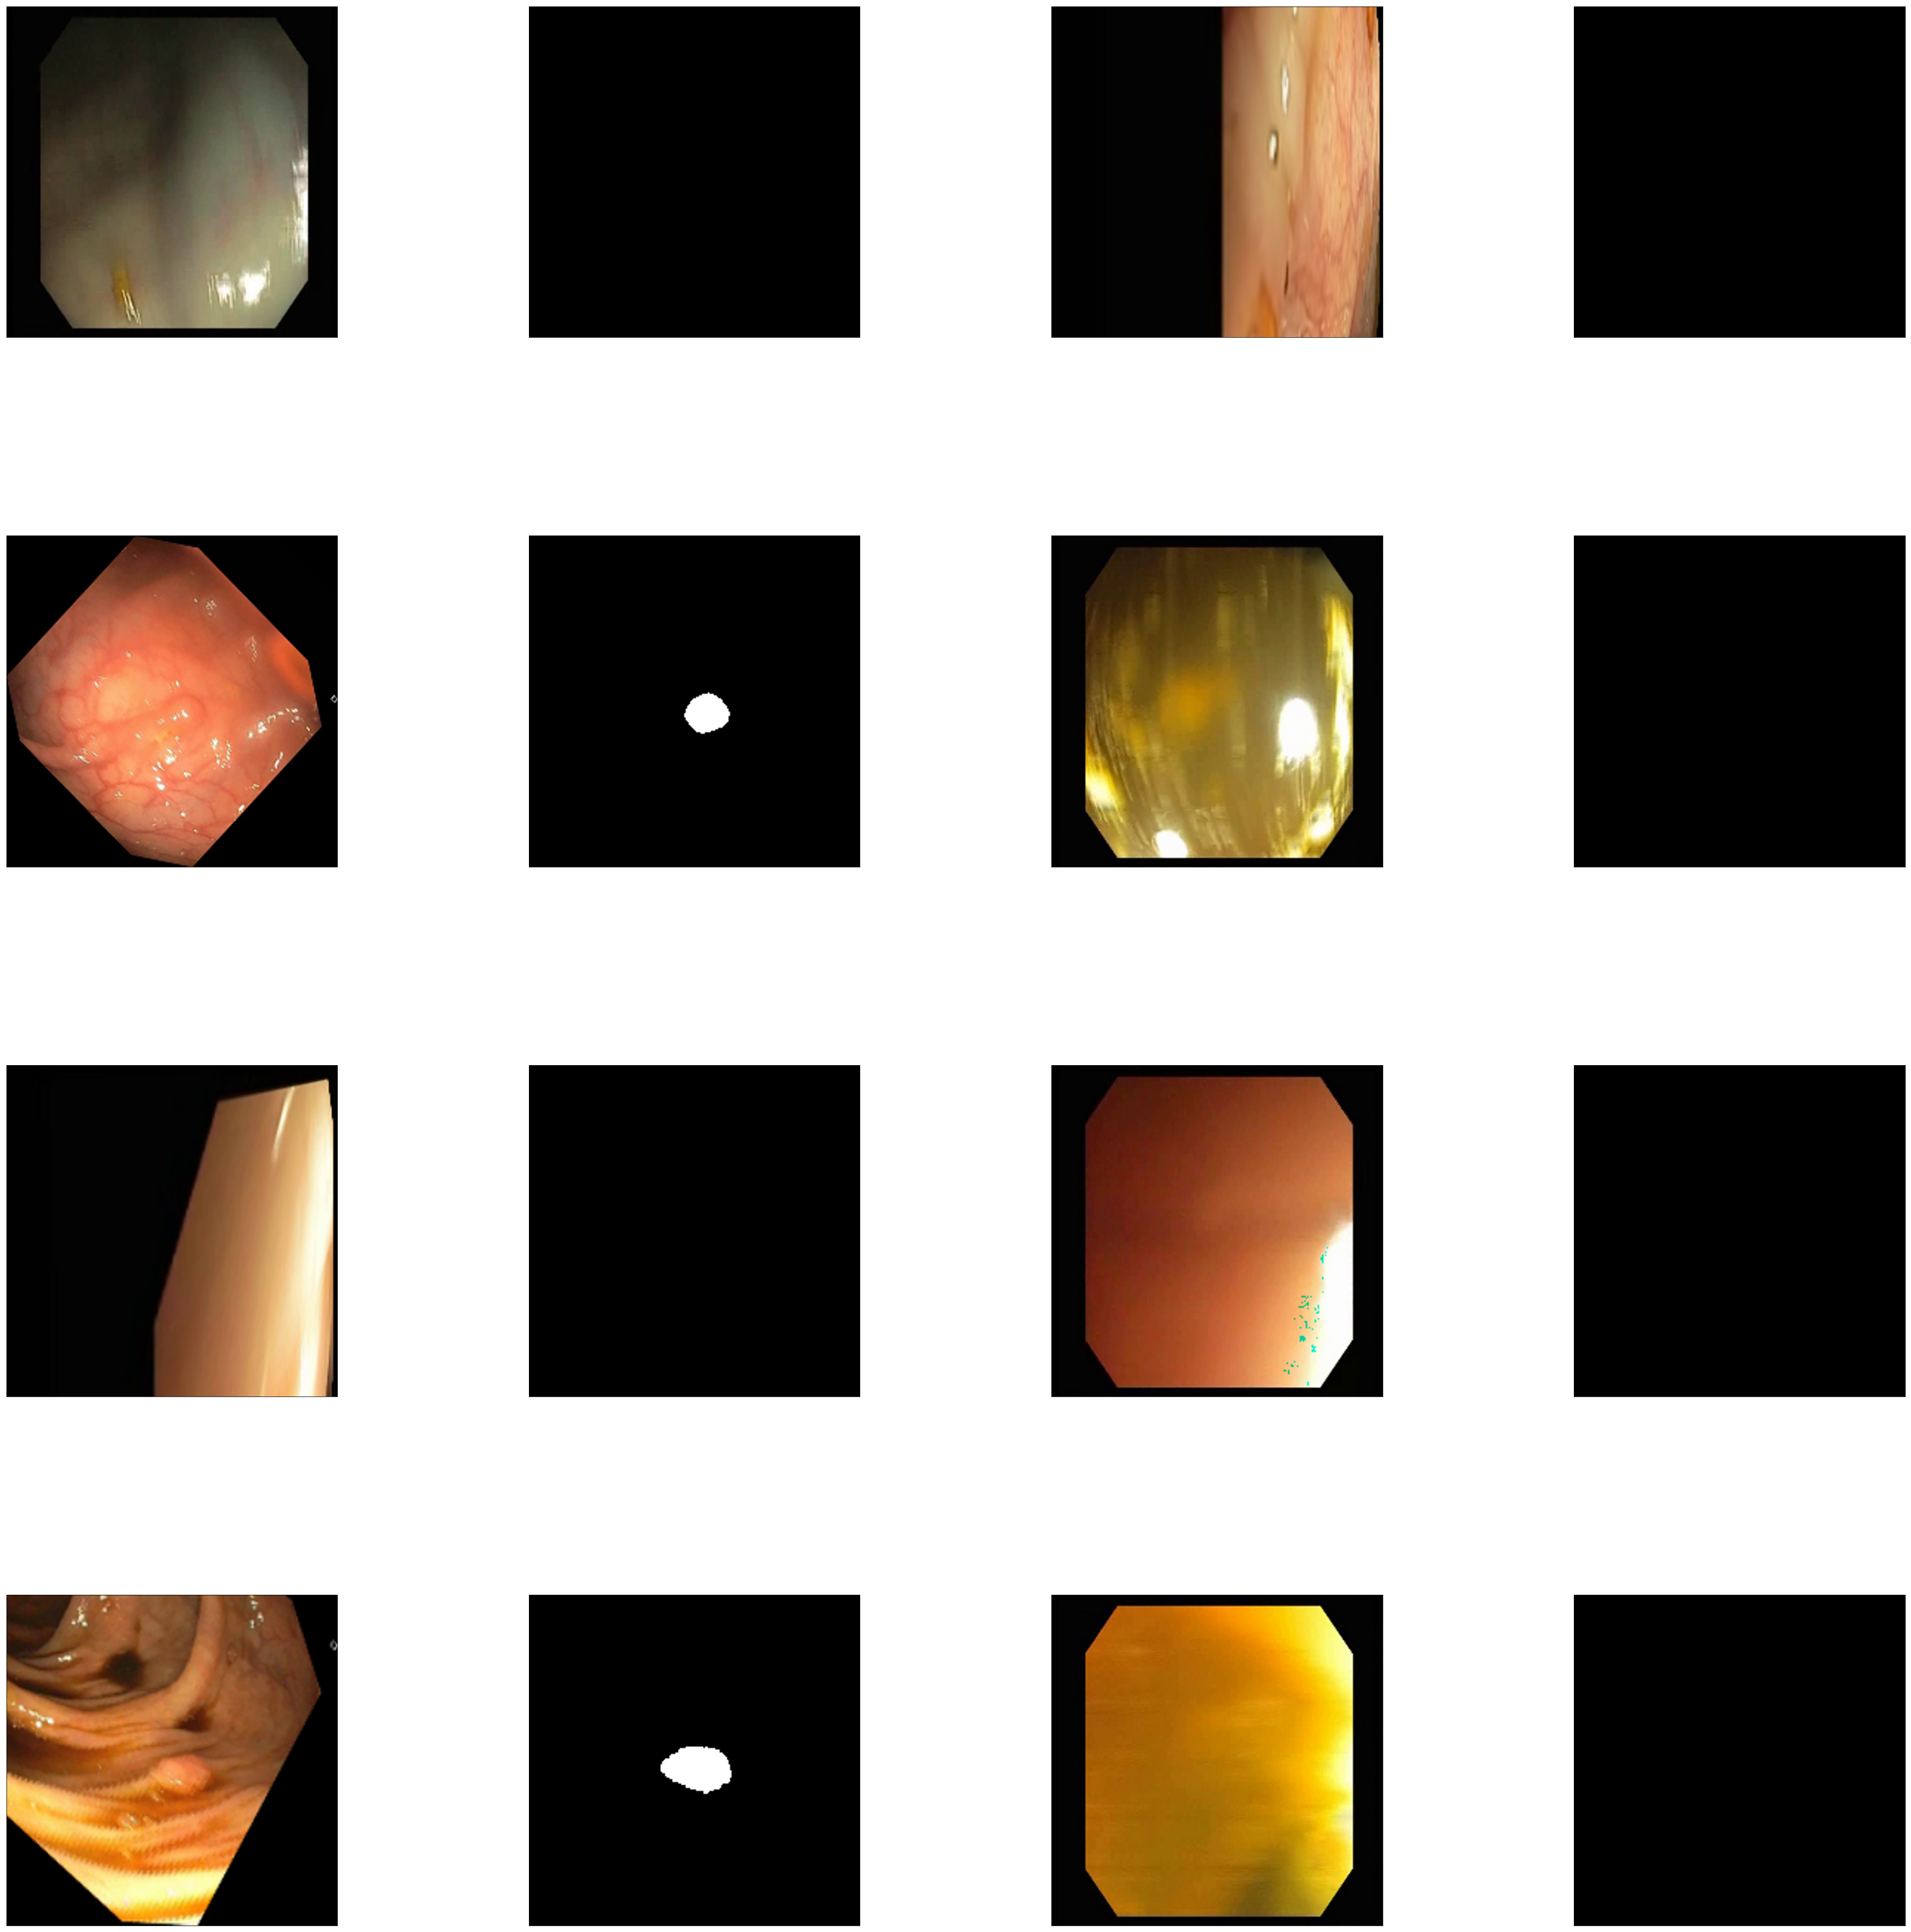

In [7]:
datagen = CustomImageDataGenerator(netparam)
trainflow=datagen.flow(imgs_trainF, imgs_mask_trainF, batch_size=8)
x_batch, y_batch = trainflow.next()
plot_imagesT((x_batch[:,:,:,0:3]*255).astype(np.uint8), np.squeeze(y_batch*255), cls_pred=None, smooth=True, filename='test.png')

In [8]:

imgs_test=[imgs_trainF[img] for img in ids_val]
imgs_mask_test=[imgs_mask_trainF[img] for img in ids_val]

#ids_val_batch = np.random.choice(len(imgs_test), size=val_num, replace=False)
imgs_test=np.array(imgs_test)
imgs_mask_test=np.array(imgs_mask_test)
#imgs_mask_test =imgs_mask_test[ids_val_batch]


In [9]:

imgs_train=[imgs_trainF[img] for img in ids_train]
imgs_mask_train=[imgs_mask_trainF[img] for img in ids_train]


imgs_train=np.array(imgs_train)
imgs_mask_train=np.array(imgs_mask_train)

In [10]:
np.shape(imgs_train)

(19155,)

In [11]:
trainflow=datagen.flow(imgs_train, imgs_mask_train, batch_size=1)
x_batch, y_batch = trainflow.next()


In [12]:
x_batch.shape

(1, 224, 224, 3)

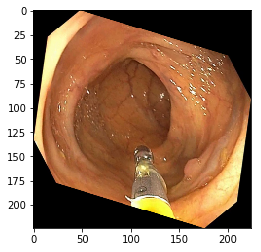

In [13]:
plt.imshow((np.squeeze(x_batch[0,:,:,:]*255)).astype(np.uint8));plt.show()

In [14]:
batchsize=10

Traindatagen = CustomImageDataGenerator(netparam)
Validdatagen= CustomImageDataGenerator(netprameval)


In [15]:

def train_generator():
    trainflow=Traindatagen.flow(imgs_train, imgs_mask_train, batch_size=batchsize)
    while True:
        x_batch, y_batch = trainflow.next()
        #pdb.set_trace()
        yield x_batch, y_batch


In [16]:

def valid_generator():
    validflow=Validdatagen.flow(imgs_test, imgs_mask_test, batch_size=batchsize)
    while True:
        x_batch, y_batch = validflow.next()
#        pdb.set_trace()
        yield x_batch, y_batch

In [17]:
model =Y_net()
filename='Y_net.hdf5'
logdirs='%s%s'%(splitext(filename)[0],'logs')

In [18]:
if  (os.path.exists(filename)):
    print("Model loaded")
    model.load_weights(filename, by_name=True)


Model loaded


In [19]:
model.summary()

plot_model(model, to_file='%s%s'%(splitext(filename)[0],'model.png'))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 6 1792        input_1[0][0]                    
__________________________________________________________________________________________________
BELblock1_conv1 (Conv2D)        (None, None, None, 6 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, None, None, 6 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
BELblock1_

In [20]:
class Shuffleindexes(Callback):
    def on_epoch_end(self, epoch, logs=None):
        """Called at the end of an epoch.
        # Arguments
            epoch: integer, index of epoch.
            logs: dictionary of logs.
        """
        super(self.__class__, self).on_epoch_end(epoch, logs)
       
        random_trainsplit(imgs_trainF=imgs_trainF,imgs_mask_trainF=imgs_mask_trainF)
        

            
        


In [21]:
def random_trainsplit(imgs_trainF=imgs_trainF,imgs_mask_trainF=imgs_mask_trainF):
        ids_train_batch = np.random.choice(len(imgs_trainF), size=len(imgs_trainF), replace=False)
        global ids_val,ids_train,imgs_train,imgs_mask_train,imgs_test,imgs_mask_test
        ids_val = ids_train_batch[: int(len(ids_train_batch)*0.2)]
        ids_train=ids_train_batch[int(len(ids_train_batch)*0.2)+1:]
        imgs_train=[imgs_trainF[img] for img in ids_train]
        imgs_mask_train=[imgs_mask_trainF[img] for img in ids_train]
        imgs_train=np.array(imgs_train)
        imgs_mask_train=np.array(imgs_mask_train)
        #Test
        
        imgs_test=[imgs_trainF[img] for img in ids_val]
        imgs_mask_test=[imgs_mask_trainF[img] for img in ids_val]

        #ids_val_batch = np.random.choice(len(imgs_test), size=val_num, replace=False)
        imgs_test=np.array(imgs_test)
        imgs_mask_test=np.array(imgs_mask_test)
        return 

In [22]:
tensorboard = TensorBoard(log_dir=logdirs)
Shuffleindexes=Shuffleindexes()
callbacks = [EarlyStopping(monitor='val_loss',
                           patience=8,
                           verbose=1,
                           min_delta=1e-4),
             ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=7,
                               verbose=1,
                               epsilon=1e-4),
             ModelCheckpoint(monitor='val_loss',
                             filepath=filename,
                             save_best_only=True,
                             save_weights_only=True),
             tensorboard]

In [23]:
history =model.fit_generator(generator=train_generator(),
                    steps_per_epoch=np.ceil(float(len(imgs_train)) / float(netparam.batch_size)),
                    epochs=netparam.nb_epoch,
                    max_queue_size=50, 
                    workers=4,
                    verbose=1,
                    callbacks=callbacks,
                    validation_data=valid_generator(),
                    validation_steps=np.ceil(float(len(imgs_test)) / float(netprameval.batch_size)))

Epoch 1/40
  30/3831 [..............................] - ETA: 52:46 - loss: 0.2549 - dice_coeff: 0.7828

KeyboardInterrupt: 

In [24]:
data.create_test_data(netprameval)
imgs_test, imgs_mask_test =data.load_test_data()
datagenTest = CustomImageDataGenerator(netprameval)
trainflow=datagenTest.flow(imgs_test, imgs_mask_test, batch_size=8)

Test set already exists and loaded from file


In [25]:

x_batch, y_batch = trainflow.next()

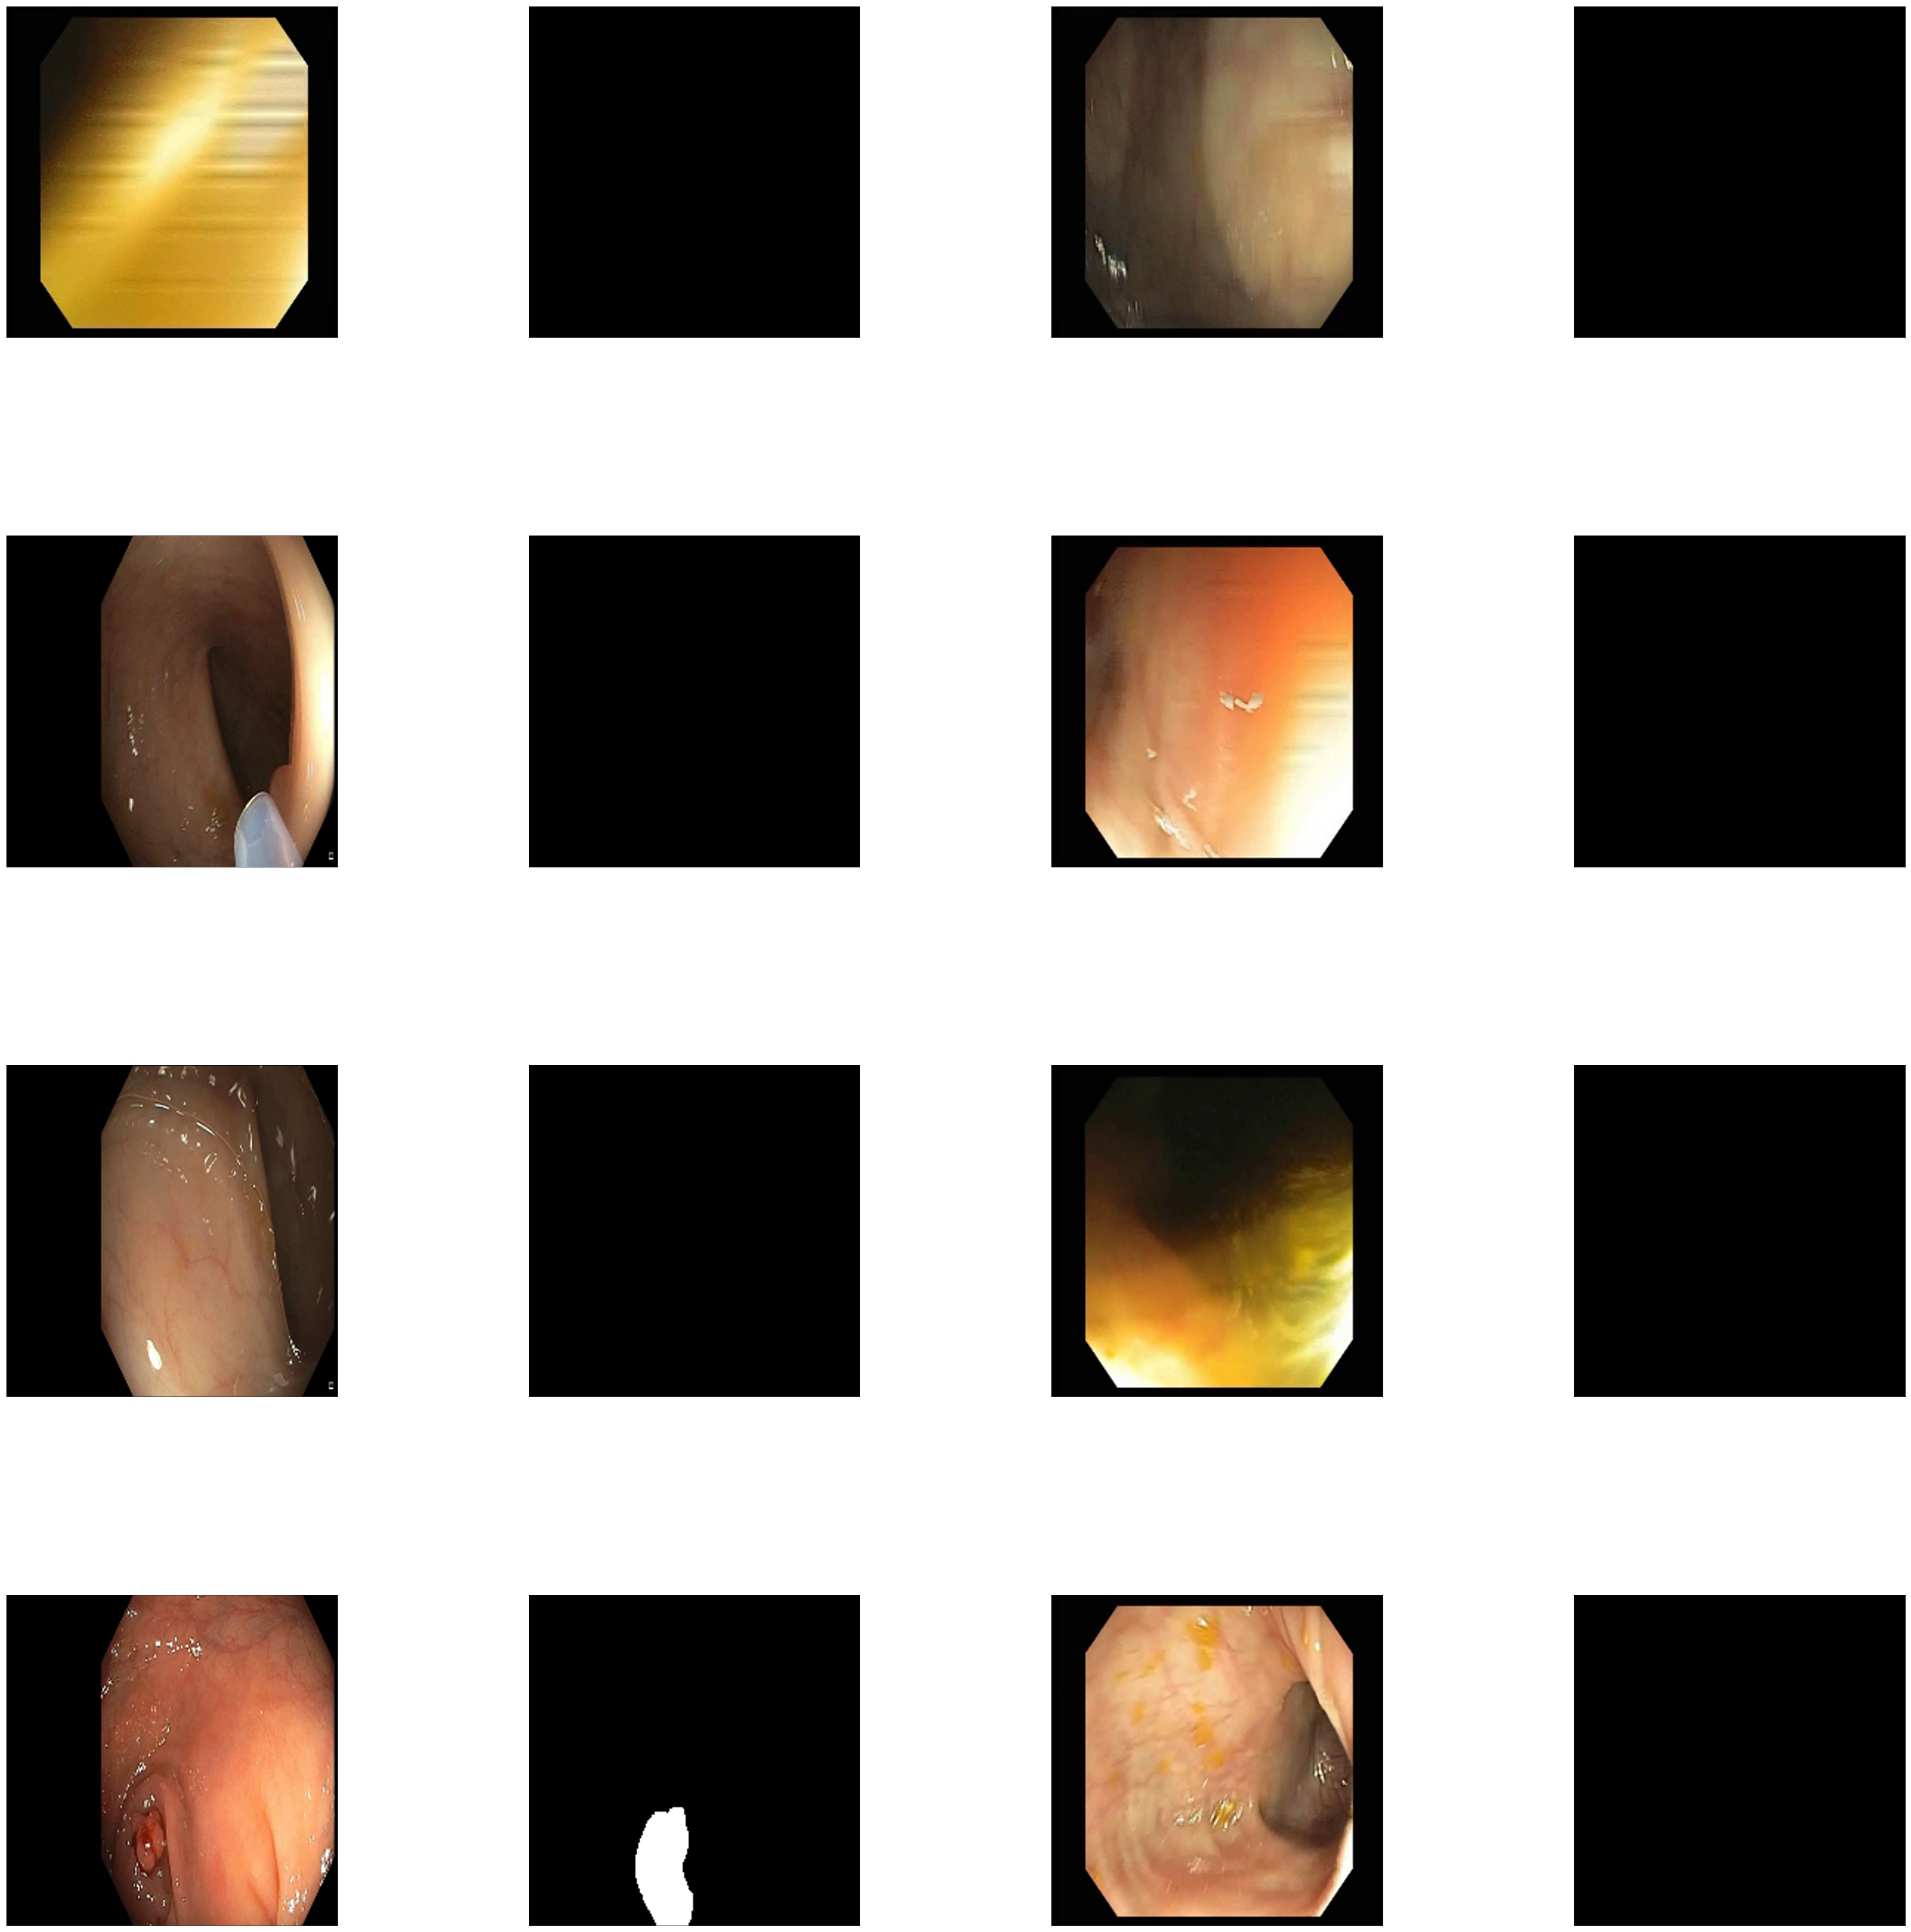

In [26]:
#Ground truth
plot_imagesT((x_batch[:,:,:,0:3]*255).astype(np.uint8), np.squeeze(y_batch*255), cls_pred=None, smooth=True, filename='result.png')

In [27]:
pred = model.predict(x_batch, batch_size=8,verbose=0)

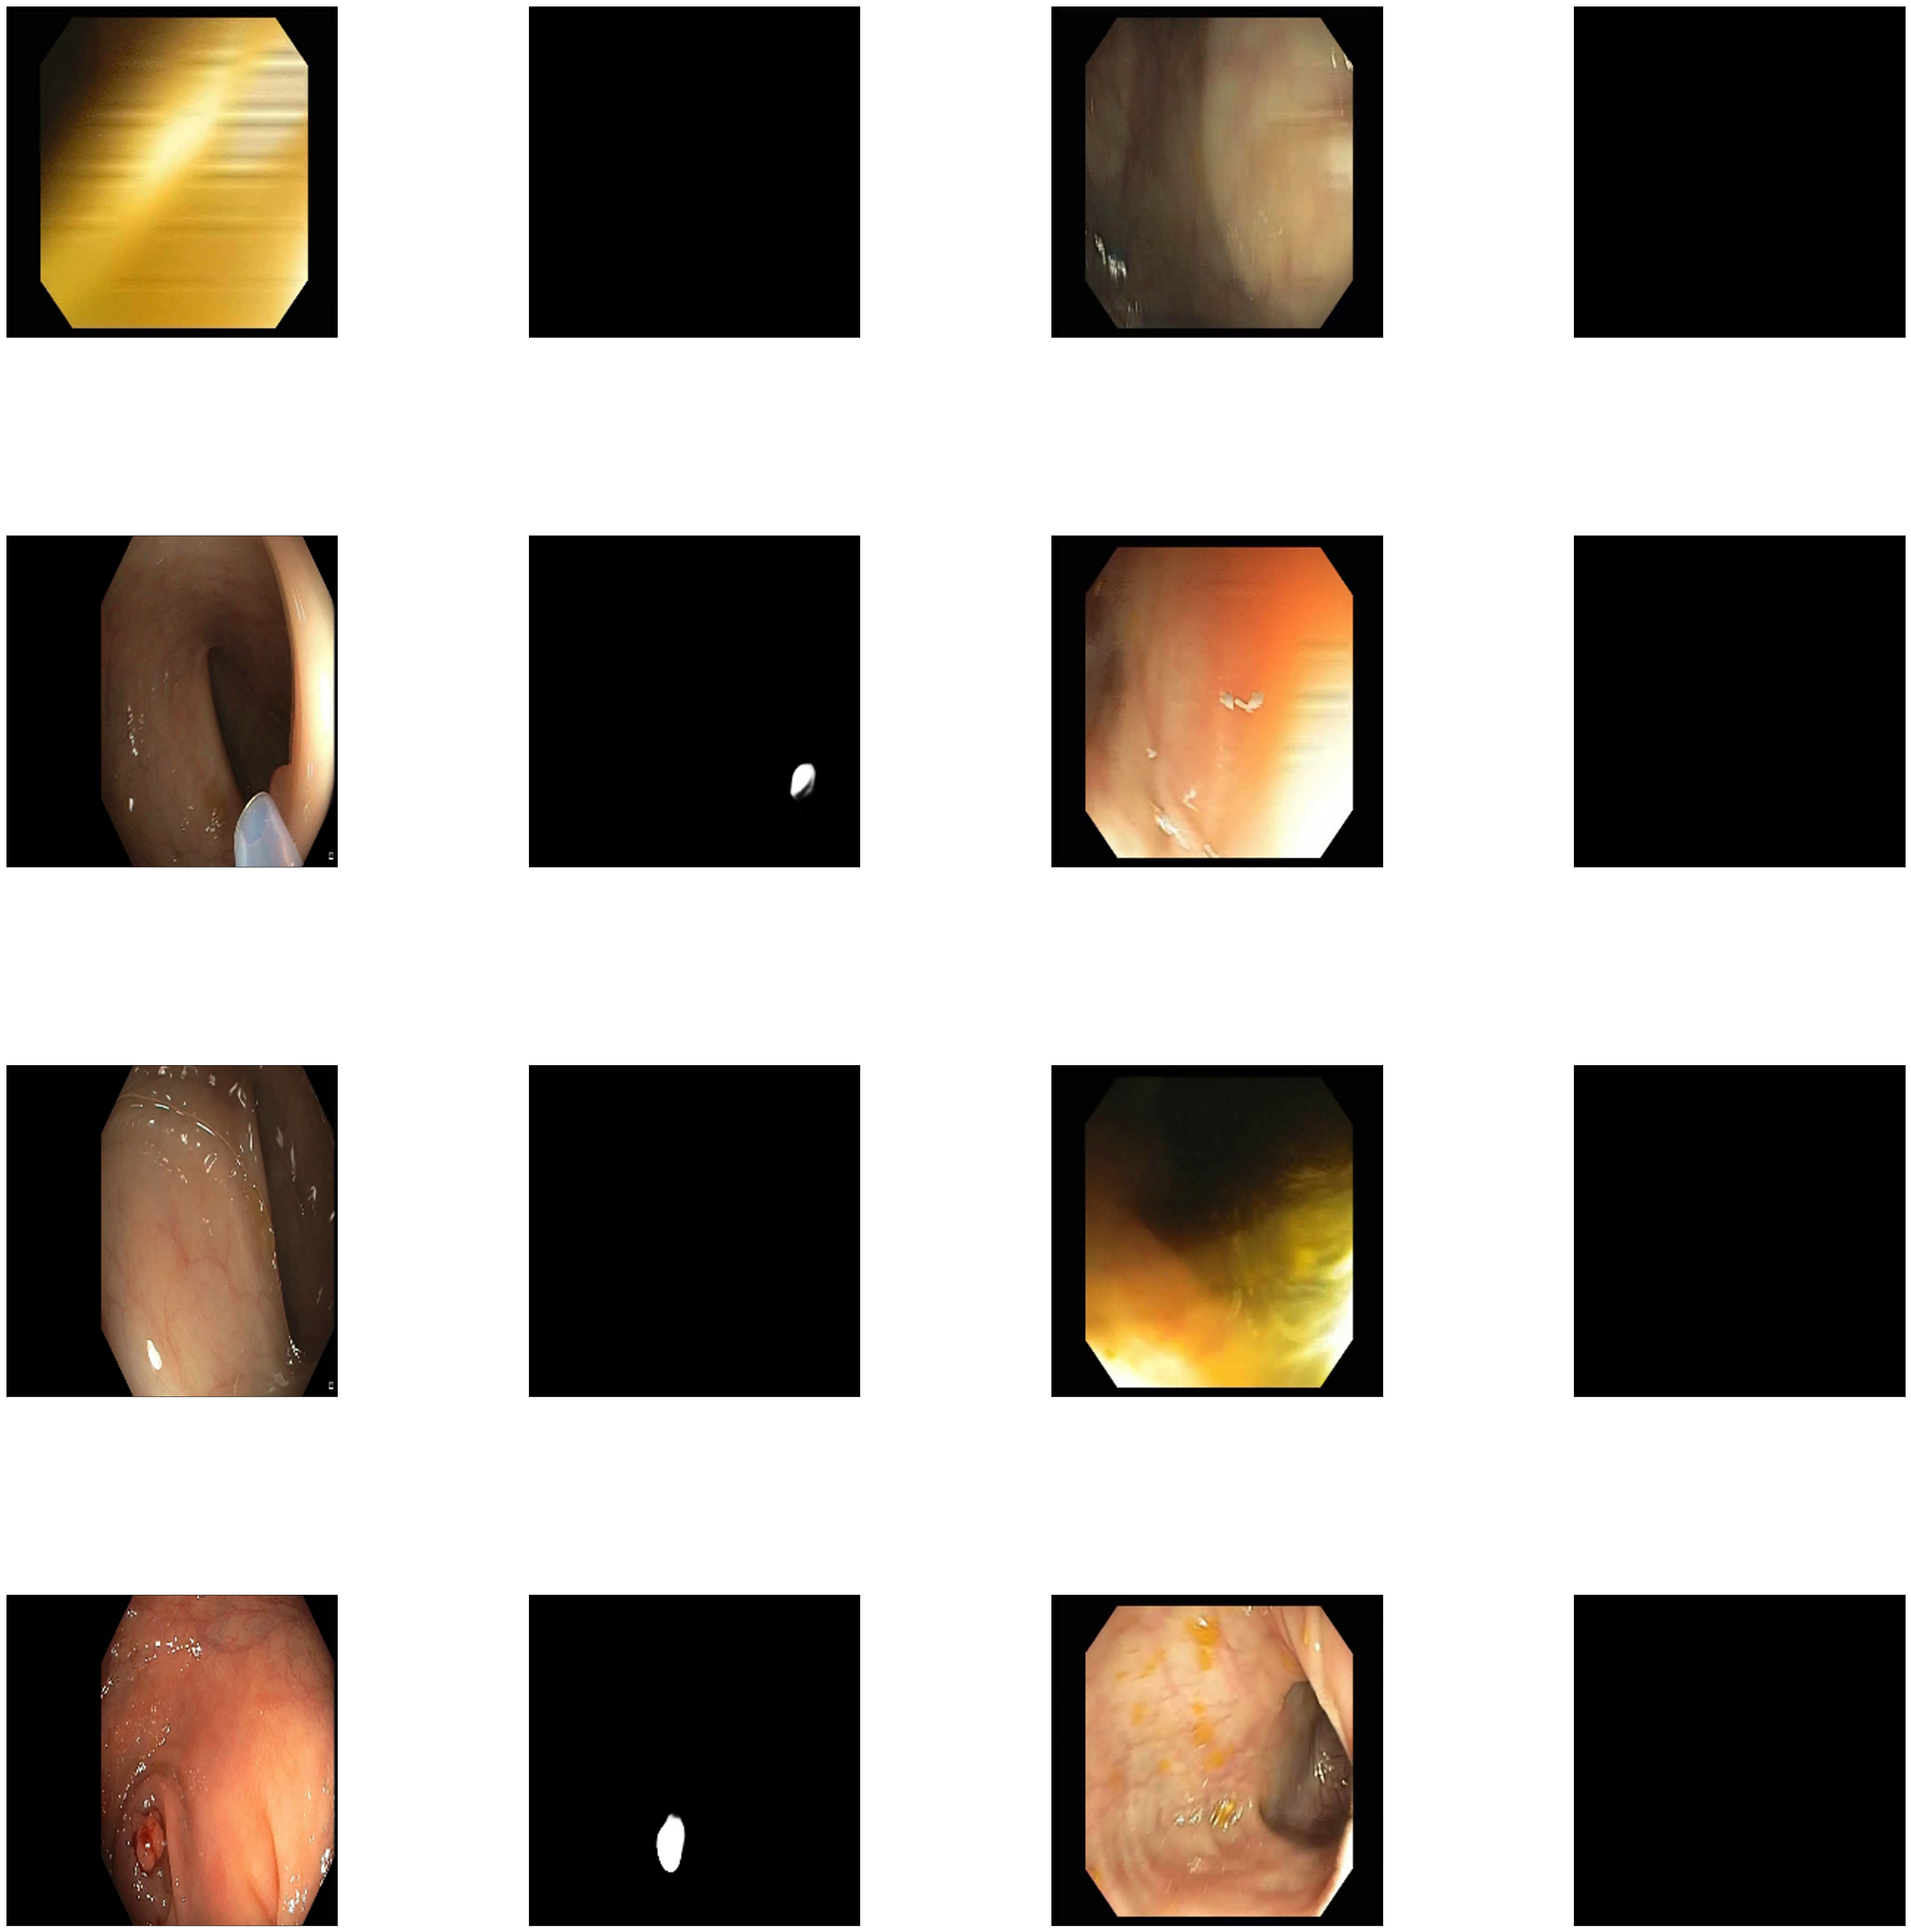

In [28]:
#Predicted
plot_imagesT((x_batch[:,:,:,0:3]*255).astype(np.uint8), np.squeeze(pred*255), cls_pred=None, smooth=True, filename='result.png')